## Imports and Setup

In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
import lightning as L
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torchmetrics.classification import Accuracy, F1Score
from torchmetrics import MetricCollection

c:\Users\saira\miniforge3\envs\fetcch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Tokenizer

In [12]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

In [13]:
sentences = ["This is an example sentence", 
            "The sun began to set, casting long shadows across the landscape. A gentle breeze rustled the leaves in the nearby trees, creating a soothing sound. It was the end of another peaceful day.",
            "Ancient civilizations often looked to the stars for guidance, weaving intricate mythologies around the celestial bodies. These stories, passed down through generations, not only explained the cosmos but also provided moral and social frameworks. Astronomers of antiquity, without the aid of modern technology, made remarkably accurate observations, charting the movements of planets and predicting eclipses with impressive precision. Their understanding of the universe, though different from ours, laid the groundwork for future scientific inquiry and our ongoing quest to comprehend the vastness of space.",
            "The intricate dance of supply and demand forms the bedrock of most modern economies, a dynamic interplay that dictates the prices of goods and services, influences production levels, and ultimately shapes employment opportunities. When demand for a particular product surges, and supply remains constant or diminishes, prices naturally tend to rise, signaling to producers that there's an unmet need in the market. Conversely, if supply outstrips demand, prices typically fall, prompting businesses to potentially scale back production or find new markets. This self-regulating mechanism, often referred to as the invisible hand, can, in theory, lead to an efficient allocation of resources. However, various factors, including government interventions like subsidies or taxes, monopolistic practices, externalities such as pollution, and unforeseen global events like pandemics or geopolitical conflicts, can significantly distort this delicate balance, leading to market inefficiencies and requiring careful economic management and policy considerations to mitigate negative consequences and promote stability and growth. Understanding these fundamental principles is crucial for individuals, businesses, and policymakers alike as they navigate the complexities of the global marketplace."
            ]

In [14]:
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

## Model Definition

In [ ]:
class SentenceTransformer(L.LightningModule):
    """
    How to pool the features to handle the temporal aspect, do we use the pooler output or manually mean pool the features. 
    """

    def __init__(self):
        super().__init__()
        self.backbone = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
        for param in self.backbone.parameters():
            param.requires_grad = False
    
    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0] 
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    def forward(self, x):
        model_output = self.backbone(**x) 
        # pooled_output = self.mean_pooling(model_output, x['attention_mask']) # mean pool
        # pooled_output = F.normalize(pooled_output, p=2, dim=1)
        # return pooled_output 
        
        return model_output.pooler_output # raw pool

In [20]:
model = SentenceTransformer()
outputs = model(encoded_input)
print(outputs.shape)

torch.Size([4, 384])


In [ ]:
outputs

tensor([[ 0.0134,  0.0400,  0.0031,  ...,  0.0389, -0.0683, -0.0096],
        [-0.0300, -0.0377,  0.0264,  ...,  0.0243, -0.0514,  0.0253],
        [-0.0254,  0.0243,  0.0588,  ..., -0.0123, -0.0427, -0.0049],
        [-0.0319, -0.0019,  0.0244,  ...,  0.0093, -0.0662,  0.0180]])

In [ ]:
for layername in model.named_modules():
    print(layername)

('', SentenceTransformer(
  (backbone): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12

### Visualizing the embeddings

In [ ]:
embeddings_np = outputs.detach().cpu().numpy()

#### Initialize a dimensionality reduction model

In [ ]:
perplexity_value = min(30.0, float(embeddings_np.shape[0] - 1))
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value, n_iter=300)


#### Fit embeddings & Visualize

In [ ]:
embeddings_2d = tsne.fit_transform(embeddings_np)

c:\Users\saira\miniforge3\envs\fetcch\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


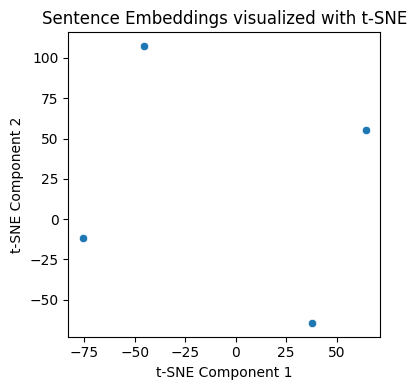

In [ ]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1])
plt.title('Sentence Embeddings visualized with t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()

### MultiTask Learning

#### Model Definition

In [ ]:
class MultiTaskSentenceTransformer(pl.LightningModule):
    """
    MultiTask Learning 
    Task A: Sentiment Analysis -> Classify sentences/reviews into predefined sentiment classes such as Happy, Sad, & Neutral 
    Task B: Named Entity Recognition -> Classify words of the sentences into prefined entity classes such as Person, Organization, Location etc.
    TODO: Describe the changes made to the architecture to support multi-task learning
    -- Added individual task specific heads to the model
    -- Updated forward to guide the logits obtained from the backbone to the respective task heads 
    -- Tried out PyTorch Lightning, a pytorch wrapper, so added the training_step to declare a single training step, same for validation and test  
    -- To accomodate the flow of the framework, the loss function and optimizer is declared in the architecture it self
    -- Added task specific metrics, Accuracy for sentiment analysis and F1 Score for named entity recognition
    """
    def __init__(self, sentiment_classes, ner_classes, dropout_rate, embedding_dim, ner_ignore_idx):
        super().__init__()
        self.backbone = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.sentiment_analysis_head = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(embedding_dim, embedding_dim//2),
            nn.ReLU(),
            nn.Linear(embedding_dim//2, sentiment_classes)
        )
        self.named_entity_rec_head = nn.Sequential(
            nn.Dropout(dropout_rate), 
            nn.Linear(embedding_dim, embedding_dim//2),
            nn.ReLU(),
            nn.Linear(embedding_dim//2, ner_classes)
        )
        self.sent_crit = nn.CrossEntropyLoss()
        self.ner_crit = nn.CrossEntropyLoss(ignore_index=ner_ignore_idx)
        self.ner_classes = ner_classes
        self.sentiment_acc = Accuracy(task="multiclass", num_classes=sentiment_classes)
        self.ner_f1 = F1Score(task="multiclass", num_classes=ner_classes, average='macro', ignore_index=ner_ignore_idx)
        
    
    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0] 
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    def forward(self, x, task, pooler_type=None):
        model_output = self.backbone(**x) 
        if task=='SEN':
            if pooler_type=='native':
                pooled_output=model_output.pooler_output
            elif pooler_type=='mean':
                pooled_output = self.mean_pooling(model_output, x['attention_mask'])
                pooled_output = F.normalize(pooled_output, p=2, dim=1)
            outputs = self.sentiment_analysis_head(pooled_output)
        if task=='NER':
            outputs = self.named_entity_rec_head(model_output.last_hidden_state)
        return outputs
    
    def configure_optimizers(self):
        trainable_params = filter(lambda p: p.requires_grad, self.parameters())
        optimizer = optim.Adam(trainable_params, lr=3e-5)
        return optimizer

    def training_step(self, batch, batch_idx):
        item = batch
        task = item.pop('task')[0]
        labels = item.pop('labels')
        pooler_type = 'mean'
        outputs = self(item, task, pooler_type)
        print(task)
        if task=='SEN':
            loss = self.sent_crit(outputs, labels)
            preds = torch.argmax(outputs, dim=1)
            acc = self.sentiment_acc(preds, labels)
            self.log("train/sentiment_acc", acc, on_step=False, on_epoch=True)
        if task=='NER':
            loss = self.ner_crit(outputs.view(-1, self.ner_classes), labels.view(-1))
            preds = torch.argmax(outputs, dim=-1)
            f1 = self.ner_f1(preds.view(-1), labels.view(-1))
            self.log("train/ner_f1", f1, on_step=False, on_epoch=True)
  
        self.log("train/loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pooler_type = 'mean'
        item = batch
        task = item.pop('task')[0]
        labels = item.pop('labels')
        outputs = self(item, task, pooler_type)
        if task=='SEN':
            loss = self.sent_crit(outputs, labels)
            preds = torch.argmax(outputs, dim=1)
            acc = self.sentiment_acc(preds, labels)
            self.log("val/sentiment_acc", acc, on_step=False, on_epoch=True)
        if task=='NER':
            loss = self.ner_crit(outputs.view(-1, self.ner_classes), labels.view(-1))
            preds = torch.argmax(outputs, dim=-1)
            f1 = self.ner_f1(preds.view(-1), labels.view(-1))
            self.log("val/ner_f1", f1, on_step=False, on_epoch=True)
        
        self.log("val/loss", loss, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        pooler_type = 'mean'
        item = batch
        task = item.pop('task')[0]
        labels = item.pop('labels')
        outputs = self(item, task, pooler_type)
        if task=='SEN':
            loss = self.sent_crit(outputs, labels)
            preds = torch.argmax(outputs, dim=1)
            acc = self.sentiment_acc(preds, labels)
            self.log("test/sentiment_acc", acc, on_step=False, on_epoch=True)
        if task=='NER':
            loss = self.ner_crit(outputs.view(-1, self.ner_classes), labels.view(-1))
            preds = torch.argmax(outputs, dim=-1)
            f1 = self.ner_f1(preds.view(-1), labels.view(-1))
            self.log("test/ner_f1", f1, on_step=False, on_epoch=True)
        self.log("test/loss", loss, on_step=False, on_epoch=True)
        return loss

In [4]:
multi_model = MultiTaskSentenceTransformer(sentiment_classes=3, ner_classes=9, dropout_rate=0.1, embedding_dim=384, ner_ignore_idx=-100)
# outputs = model(encoded_input)
# print(outputs.shape[-1])

In [5]:
multi_model

MultiTaskSentenceTransformer(
  (backbone): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1

In [6]:
print("\nTrainable Parameters")
for name, param in multi_model.named_parameters():
    if param.requires_grad:
        print(name)


Trainable Parameters
sentiment_analysis_head.1.weight
sentiment_analysis_head.1.bias
sentiment_analysis_head.3.weight
sentiment_analysis_head.3.bias
named_entity_rec_head.1.weight
named_entity_rec_head.1.bias
named_entity_rec_head.3.weight
named_entity_rec_head.3.bias


#### Data preparation

##### Sentiment Analysis Data

In [11]:
sentiment_data = ["This movie was absolutely fantastic! The acting was superb and the storyline was gripping.", 
                  "I'm quite disappointed with the product quality; it broke after just one day of use.", 
                  "The weather today is partly cloudy with a chance of showers later in the afternoon.", 
                  "Customer service was incredibly helpful and resolved my issue in no time!",
                  "The new software update seems a bit clunky and not very intuitive to navigate."]
sentiment_labels = ["Positive", "Negative", "Neutral", "Positive", "Negative"]


##### Named Entity Recognition Data

In [7]:
ner_data = [
    {
        "sentence": "Anna Wintour works for Vogue in New York City.",
        "tokens_tags": [
            ("Anna", "B-PER"),
            ("Wintour", "I-PER"),
            ("works", "O"),
            ("for", "O"),
            ("Vogue", "B-ORG"),
            ("in", "O"),
            ("New", "B-LOC"),
            ("York", "I-LOC"),
            ("City", "I-LOC"),
            (".", "O")
        ]
    },
    {
        "sentence": "The G7 summit will be held in London next June.",
        "tokens_tags": [
            ("The", "O"),
            ("G7", "B-ORG"), 
            ("summit", "O"),
            ("will", "O"),
            ("be", "O"),
            ("held", "O"),
            ("in", "O"),
            ("London", "B-LOC"),
            ("next", "B-MISC"), 
            ("June", "I-MISC"), 
            (".", "O")
        ]
    },
    {
        "sentence": "Elon Musk announced that SpaceX will launch Starship next month.",
        "tokens_tags": [
            ("Elon", "B-PER"),
            ("Musk", "I-PER"),
            ("announced", "O"),
            ("that", "O"),
            ("SpaceX", "B-ORG"),
            ("will", "O"),
            ("launch", "O"),
            ("Starship", "B-MISC"), 
            ("next", "O"),
            ("month", "O"),
            (".", "O")
        ]
    },
    {
        "sentence": "The FIFA World Cup is a global football tournament organized by FIFA.",
        "tokens_tags": [
            ("The", "O"),
            ("FIFA", "B-ORG"), 
            ("World", "I-MISC"), 
            ("Cup", "I-MISC"),   
            ("is", "O"),
            ("a", "O"),
            ("global", "O"),
            ("football", "O"),
            ("tournament", "O"),
            ("organized", "O"),
            ("by", "O"),
            ("FIFA", "B-ORG"),
            (".", "O")
        ]
    },
    {
        "sentence": "Barack Obama visited Berlin during his presidency.",
        "tokens_tags": [
            ("Barack", "B-PER"),
            ("Obama", "I-PER"),
            ("visited", "O"),
            ("Berlin", "B-LOC"),
            ("during", "O"),
            ("his", "O"),
            ("presidency", "O"),
            (".", "O")
        ]
    }
]

##### Dataset Class

In [19]:
class SentimentDatasetClass(Dataset):
    def __init__(self, sentiment_data, sentiment_labels):
        self.texts = sentiment_data
        self.labels = sentiment_labels
        self.tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
        self.max_length = 128

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['task'] = "SEN"
        return item

In [20]:
sent_label_id = {"Positive":0, "Negative":1, "Neutral":2}
sent_labels = [sent_label_id[lbl] for lbl in sentiment_labels]
testdata = SentimentDatasetClass(sentiment_data=sentiment_data, sentiment_labels=sent_labels)

In [21]:
testdl = DataLoader(testdata, batch_size=2, shuffle=True)

In [22]:
for batch in testdl:
    print(batch)
    task = batch.pop('task')[0]
    labels = batch.pop('labels')
    print(batch, task)
    break

{'input_ids': tensor([[  101,  1996,  4633,  2651,  2003,  6576, 24706,  2007,  1037,  3382,
          1997, 23442,  2101,  1999,  1996,  5027,  1012,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [ ]:
testdata.__getitem__(1)

{'input_ids': tensor([ 101, 1045, 1005, 1049, 3243, 9364, 2007, 1996, 4031, 3737, 1025, 2009,
         3631, 2044, 2074, 2028, 2154, 1997, 2224, 1012,  102,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0

In [ ]:
class NERDatasetClass(Dataset):
    def __init__(self, ner_data, ner_ignore_idx):
        self.ner_label_to_id = {
                    "O":0,
                    "B-PER": 1,
                    "I-PER": 2,
                    "B-LOC": 3,
                    "I-LOC": 4,
                    "B-ORG": 5,
                    "I-ORG": 6,
                    "B-MISC": 7,
                    "I-MISC": 8
                }
        self.id_to_ner_label = {v: k for k, v in self.ner_label_to_id.items()}
        self.tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
        self.ner_ignore_idx = ner_ignore_idx
        self.data = []
        for item in ner_data:
            tokens, tags = zip(*item["tokens_tags"])
            tag_ids = [self.ner_label_to_id[tag] for tag in tags]
            self.data.append({
                "tokens": list(tokens),
                "labels": tag_ids,
                "task": "NER"
            })

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        words = item["tokens"]
        labels = item["labels"]
        encoded = self.tokenizer(words, is_split_into_words=True, return_tensors='pt',
                                     padding='max_length', max_length=128, truncation=True)
        word_ids = encoded.word_ids(0)
        aligned_labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels.append(self.ner_ignore_idx)
            elif word_idx != previous_word_idx:
                aligned_labels.append(labels[word_idx])
            else:
                aligned_labels.append(-100)
        previous_word_idx = word_idx
        item = {key: val.squeeze(0) for key, val in encoded.items()}
        item["labels"] = torch.tensor(aligned_labels)
        item['task'] = "NER"
        return item

In [9]:
nertest = NERDatasetClass(ner_data=ner_data, ner_ignore_idx=-100)

In [10]:
nertest.__getitem__(1)

{'input_ids': tensor([ 101, 1996, 1043, 2581, 6465, 2097, 2022, 2218, 1999, 2414, 2279, 2238,
         1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0

##### Dataloader

In [ ]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

### Training and Testing

In [ ]:
"""
TODO: How the model should be trained given the following:
1. If the entire network should be frozen.
-- In this case, there would be no layers to train, no parameters would be updated, and the network would 
    act as a feature extractor, and the logits would be passed to a classifier head to obtain the output,
    its not too beneficial as the model would not learn from the mistakes its making.
2. If only the transformer backbone should be frozen.
-- In this case, with the backbone only frozen, the fixed representations allow us the freedom to tune the 
    task specific layers, while preserving the knowledge from backbone, this way the task heads effectively 
    learn the task specific information.  
3. If only one of the task-specific heads (either for Task A or Task B) should be frozen.
-- This is ideal when let's say the the frozen model performance on Task A is good while it suffers on Task B
    so by freezing the layers of Task A head, we can preserve the performance on Task A, while allowing the 
    the model to be better at Task B.

TODO: Explain how you would approach the transfer learning process, including:
1. The choice of a pre-trained model.
-- Choosing a pre-trained model that is closer to the task at hand is beneficial, as we can use the learned 
    knowledge for features closer to the task, better features equal better performance.
2. The layers you would freeze/unfreeze.
-- Freeze the early layers, unfreeze the later layers, the ones closer to task specific heads.
3. The rationale behind these choices.
-- The earlier layers in a transformer model tend to learn the general information better, 
    as compared to the later layers, which learn the task specific information. 
"""


trainer_config = {
        "max_epochs": 20, 
        "precision": "16-mixed" if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 32,
        "logger": pl.loggers.TensorBoardLogger("training_logs/", name="mtl_sentiment_ner"),
        "callbacks": [
            pl.callbacks.ModelCheckpoint(monitor="val/loss", mode="min", save_top_k=1),
            pl.callbacks.EarlyStopping(monitor="val/loss", mode="min", patience=3)
        ]
    }

if torch.cuda.is_available():
    trainer_config["accelerator"] = "gpu"
    trainer_config["devices"] = 1 
    print(f"Training on GPU: {torch.cuda.get_device_name(0)}")
else:
    trainer_config["accelerator"] = "cpu"
    print("Training on CPU")

trainer = pl.Trainer(**trainer_config)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training on GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [32]:
from torch.utils.data import DataLoader
from pytorch_lightning import LightningDataModule

class SentimentDataModule(LightningDataModule):
    def __init__(self, sentiment_data, sentiment_labels, batch_size):
        super().__init__()
        self.train_texts = sentiment_data
        self.train_labels = sentiment_labels
        self.val_texts = sentiment_data
        self.val_labels = sentiment_labels
        self.test_texts = sentiment_data
        self.test_labels = sentiment_labels
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = SentimentDatasetClass(self.train_texts, self.train_labels)
        self.val_dataset = SentimentDatasetClass(self.val_texts, self.val_labels)
        self.test_dataset = SentimentDatasetClass(self.test_texts, self.test_labels)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

In [ ]:
"""
TODO: Explain any assumptions or decisions made paying special attention to how training within a MTL framework operates.
--  The training procedure operates with the assumption, each tasks are trained independently and not together,
    to handle this condition, we have defined the forward function of the model to drive the backbone outputs in the 
    respective task-specific heads. We also need to use the appropriate loss function for each of the tasks, it is especially 
    cruicial, this is handled in the training step where we use the approprite loss function.
    I tried building a combined Dataset class and loader, but that was unseuccessful as the dataloader could not stack 
    the labels of different shape(1 for sentiment analysis, 128 for NER).
"""

In [33]:
sentiment_dm = SentimentDataModule(sentiment_data=sentiment_data, sentiment_labels=sent_labels, batch_size=2)

In [ ]:
trainer.fit(multi_model, datamodule=sentiment_dm)
trainer.test(multi_model, datamodule=sentiment_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type               | Params | Mode 
-----------------------------------------------------------------------
0 | backbone                | BertModel          | 22.7 M | eval 
1 | sentiment_analysis_head | Sequential         | 74.5 K | train
2 | named_entity_rec_head   | Sequential         | 75.7 K | train
3 | sent_crit               | CrossEntropyLoss   | 0      | train
4 | ner_crit                | CrossEntropyLoss   | 0      | train
5 | sentiment_acc           | MulticlassAccuracy | 0      | train
6 | ner_f1                  | MulticlassF1Score  | 0      | train
-----------------------------------------------------------------------
150 K     Trainable params
22.7 M    Non-trainable params
22.9 M    Total params
91.453    Total estimated model params size (MB)
14        Modules in train mode
120       Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]IN MODEL DEF SEN
tensor([[-0.0787,  0.0109,  0.0268],
        [-0.0703,  0.0027,  0.0213]], device='cuda:0', dtype=torch.float16)
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 44.10it/s]IN MODEL DEF SEN
tensor([[-0.0800, -0.0123,  0.0278],
        [-0.0697, -0.0055,  0.0208]], device='cuda:0', dtype=torch.float16)
Epoch 0:   0%|          | 0/3 [00:00<?, ?it/s]                             IN MODEL DEF SEN
tensor([[-0.0813, -0.0094,  0.0325],
        [-0.0735,  0.0096,  0.0238]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
SEN
Epoch 0:  33%|███▎      | 1/3 [00:00<00:00, 37.89it/s, v_num=10]IN MODEL DEF SEN
tensor([[-0.0666, -0.0103,  0.0192],
        [-0.0454,  0.0057,  0.0286]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)
SEN
Epoch 0:  67%|██████▋   | 2/3 [00:00<00:00, 40.76it/s, v_num=10]IN MODEL DEF SEN
tensor([[-0.0604,  0.0079,  0.0179]], device

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 3/3 [00:00<00:00,  7.91it/s, v_num=10]


In [12]:
from torch.utils.data import DataLoader
from pytorch_lightning import LightningDataModule

class NERDataModule(LightningDataModule):
    def __init__(self, ner_data, ner_ignore_idx, batch_size):
        super().__init__()
        self.ner_data = ner_data
        self.ner_ignore_idx = ner_ignore_idx
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = NERDatasetClass(self.ner_data, self.ner_ignore_idx)
        self.val_dataset = NERDatasetClass(self.ner_data, self.ner_ignore_idx)
        self.test_dataset = NERDatasetClass(self.ner_data, self.ner_ignore_idx)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

In [13]:
ner_dm = NERDataModule(ner_data=ner_data, ner_ignore_idx=-100, batch_size=2)

In [ ]:
trainer.fit(multi_model, datamodule=ner_dm)
trainer.test(multi_model, datamodule=ner_dm)

You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type               | Params | Mode 
-----------------------------------------------------------------------
0 | backbone                | BertModel          | 22.7 M | eval 
1 | sentiment_analysis_head | Sequential         | 74.5 K | train
2 | named_entity_rec_head   | Sequential         | 75.7 K | train
3 | sent_crit               | CrossEntropyLoss   | 0      | train
4 | ner_crit                | CrossEntropyLoss   | 0      | train
5 | sentiment_acc           | MulticlassAccuracy | 0      | train
6 | ner_f1                  | MulticlassF1Score 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\saira\miniforge3\envs\fetcch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


c:\Users\saira\miniforge3\envs\fetcch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
c:\Users\saira\miniforge3\envs\fetcch\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 19: 100%|██████████| 3/3 [00:00<00:00, 29.30it/s, v_num=12]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 3/3 [00:00<00:00,  7.24it/s, v_num=12]
